In [430]:
import pandas as pd
import seaborn as sns
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm
import matplotlib.patches as mpatches
from utils import *
import matplotlib.colors as mcolors



In [431]:
def visualize(dimensions, problems, algorithms, runs, line_plot_y=False, plot_y=False, data_dir=None, save=False):
    if data_dir is None:
        data_dir=f'../data/clustering_features_x_only'
    for dimension in dimensions:
        directory=f'{data_dir}/cluster_distributions/dim_{dimension}'
        for problem in problems:
            cluster_centers=pd.read_csv(f'{data_dir}/cluster_centers/dim_{dimension}/{problem}.csv',index_col=0)
            
            print(cluster_centers)
            cluster_centers = {index: ', '.join([ str(round(row[c],2)) for c in row.keys()]) for index, row in cluster_centers.iterrows()}
            print(cluster_centers)
            solutions=pd.read_parquet(f'{data_dir}/clustering_results/dim_{dimension}/{problem}.parquet')
            file_loc=f'{directory}/{problem}.csv'
            if os.path.isfile(file_loc):
                df=pd.read_csv(file_loc,index_col=[0,1,2])
                df.columns=[f'{int(c)} (Center: {cluster_centers[int(c)]})' for c in df.columns]
                for a in algorithms:
                    for run in runs:
                        print(problem,a,run)

                        s = solutions.query('algorithm==@a and run==@run').groupby(['iteration', 'cluster'])['scaled_raw_y']
                        s_min=s.min().cummin().to_frame().reset_index()
                        print(s_min)
                        #s_mean=s.mean().to_frame().reset_index()
                        #s_stats = pd.concat([s_min.assign(stat='min'), s_mean.assign(stat='mean')])
                        
                        # Create a figure with subplots
                        fig, axes = plt.subplots(1, 2 if plot_y else 1, figsize=(15 if plot_y else 7, int(s_min['iteration'].max() / 3 )), squeeze=False)
                        axes=axes[0]
                        print(axes[0])

                        # Plot the line plot on the first axis

                        if plot_y:
                            if line_plot_y:
                                sns.lineplot(data=s_min, x='iteration', y='scaled_raw_y', hue='cluster', style='cluster',palette='tab10',markers=True, dashes=False, ax=axes[1])
                                ax1.set_title('Minimum scaled y per cluster and iteration')
                                ax1.set_xlabel('Iteration')
                                ax1.set_ylabel('Scaled Raw Y')
                            else:
                                s_min_pivoted=s_min.pivot(index='iteration', columns='cluster', values='scaled_raw_y')
                                s_min_pivoted.columns=[f'{int(c)} (Center: {cluster_centers[int(c)]})' for c in s_min_pivoted.columns]
                                sns.heatmap(s_min_pivoted, annot=True,ax=axes[1],cmap="YlGnBu", fmt=".3f",norm=mcolors.LogNorm())
                        
                        # Plot the heatmap on the second axis
                        sns.heatmap(df.loc[a, run].replace(0,np.nan), annot=True, ax=axes[0],cmap='YlGnBu')

                        
                        # Adjust layout
                        plt.tight_layout()
                        if save:
                            file_name=f'{problem}_{a}_run_{run}.pdf'
                            plt.savefig('figures_clustering_new/{file_name}',bbox_inches=0)
                        # Show the combined plot
                        plt.show()
                        
                        '''plt.figure()
                        sns.lineplot(s,x='iteration',y='scaled_raw_y', hue='cluster',palette='tab10')
                        plt.show()
                        
                        plt.figure(figsize=(5,dimension*2))
                        sns.heatmap(df.loc[a,run].T,annot=True)
                        plt.show()'''

In [432]:
def visualize_multi(dimensions, problems, algorithms, runs, line_plot_y=False, plot_y=False, data_dir=None, save=False, popsize=50):
    if data_dir is None:
        data_dir=f'../data/clustering_features_x_only'
    for dimension in dimensions:
        directory=f'{data_dir}/cluster_distributions/dim_{dimension}'
        for problem in problems:
            cluster_centers=pd.read_csv(f'{data_dir}/cluster_centers/dim_{dimension}/{problem}.csv',index_col=0)
            print(cluster_centers)
            cluster_count=cluster_centers.shape[0]
            cluster_centers = {index: ', '.join([ str(round(row[c],2)) for c in row.keys()]) for index, row in cluster_centers.iterrows()}
            print(cluster_centers)
            solutions=pd.read_parquet(f'{data_dir}/clustering_results/dim_{dimension}/{problem}.parquet')
            file_loc=f'{directory}/{problem}.csv'
            if os.path.isfile(file_loc):
                df=pd.read_csv(file_loc,index_col=[0,1,2])
                df.columns=[f'{int(c)} (Center: {cluster_centers[int(c)]})' for c in df.columns]
                fig, all_axes = plt.subplots(len(algorithms), 2 if plot_y else 1, figsize=(cluster_count if plot_y else 10, 3*dimension * len(algorithms)), squeeze=False, sharex=True)
                for a_index, a in enumerate(algorithms):
                    for run in runs:
                        print(problem,a,run)

                        s = solutions.query('algorithm==@a and run==@run').groupby(['iteration', 'cluster'])['scaled_raw_y']
                        s_min=s.min().to_frame().reset_index()
                        #s_mean=s.mean().to_frame().reset_index()
                        #s_stats = pd.concat([s_min.assign(stat='min'), s_mean.assign(stat='mean')])
                        
                        # Create a figure with subplots
                        #fig, axes = plt.subplots(1, 2 if plot_y else 1, figsize=(15 if plot_y else 7, int(s_min['iteration'].max() / 3 )), squeeze=False)
                        axes=all_axes[a_index]

                        # Plot the line plot on the first axis
                        axes[0].set_title(f'Algorithm: {a}; Run: {run}')
                        if plot_y:
                            if line_plot_y:
                                sns.lineplot(data=s_min, x='iteration', y='scaled_raw_y', hue='cluster', style='cluster',palette='tab10',markers=True, dashes=False, ax=axes[1])
                                ax1.set_title('Minimum scaled y per cluster and iteration')
                                ax1.set_xlabel('Iteration')
                                ax1.set_ylabel('Scaled Raw Y')
                            else:
                                s_min_pivoted=s_min.pivot(index='iteration', columns='cluster', values='scaled_raw_y')
                                s_min_pivoted.columns=[f'{int(c)} (Center: {cluster_centers[int(c)]})' for c in s_min_pivoted.columns]
                                sns.heatmap(s_min_pivoted, annot=True,ax=axes[1], vmin=0, vmax=1)
                        
                        # Plot the heatmap on the second axis
                        sns.heatmap(df.loc[a, run].replace(0,np.nan), annot=True, ax=axes[0], vmin=0, vmax=popsize,cmap='YlGnBu')

                        
                        # Adjust layout
                
                plt.tight_layout()
                plt.margins(0, tight=True)
                if save:
                    file_name=f"{data_dir.split('/')[-1]}_{problem}_{'+'.join(algorithms)}_run_{'+'.join([str(r) for r in runs])}.pdf"
                    plt.savefig(f'figures_clustering_new/{file_name}',bbox_inches='tight', pad_inches=0)
                # Show the combined plot
                plt.show()

    scaled_x0  scaled_x1
0   -0.815440  -1.481365
1    2.003826   1.399467
2   -4.951525  -4.939109
3   -3.369785   2.282118
4    4.686800  -3.288029
..        ...        ...
59   1.638659   2.986428
60  -0.165248  -0.452813
61   3.188716  -3.742453
62  -0.868418  -1.223671
63  -2.435360   1.204676

[64 rows x 2 columns]
{0: '-0.82, -1.48', 1: '2.0, 1.4', 2: '-4.95, -4.94', 3: '-3.37, 2.28', 4: '4.69, -3.29', 5: '-3.31, -1.46', 6: '0.23, -4.55', 7: '0.12, 0.26', 8: '4.86, 4.83', 9: '-3.18, -2.61', 10: '4.53, -0.39', 11: '-1.19, 4.63', 12: '1.77, -1.1', 13: '-2.58, -4.8', 14: '-1.36, -0.72', 15: '-1.71, -2.86', 16: '1.66, -2.49', 17: '-4.8, 4.75', 18: '-4.73, -3.51', 19: '2.96, 3.4', 20: '-0.18, -1.25', 21: '-4.73, -0.93', 22: '-0.78, 1.23', 23: '0.46, -1.78', 24: '4.71, 2.93', 25: '-2.29, -1.01', 26: '-3.32, -0.09', 27: '-0.98, -0.91', 28: '2.94, 4.84', 29: '0.91, 2.01', 30: '-2.17, -2.0', 31: '1.95, -4.51', 32: '-1.94, 0.08', 33: '-1.19, -1.99', 34: '-0.59, -0.81', 35: '-3.69, -4.71',

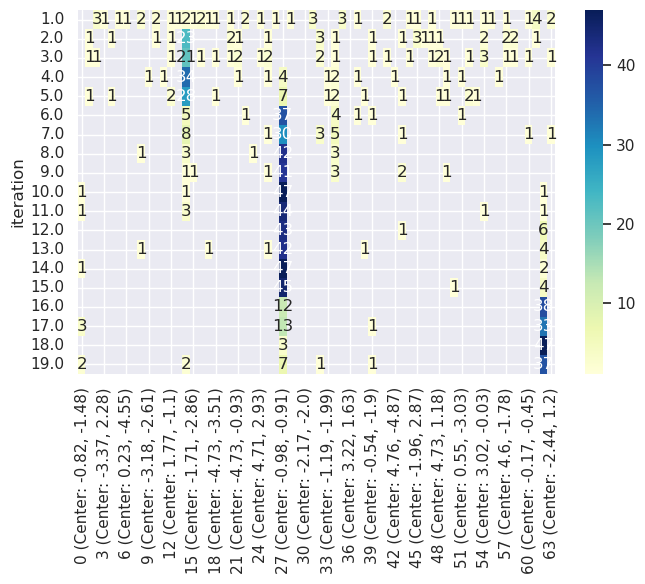

F14_I1_2D AugmentedAEO 1
     iteration  cluster  scaled_raw_y
0          1.0        1      0.017451
1          1.0        2      0.017451
2          1.0        3      0.017451
3          1.0        5      0.006311
4          1.0        6      0.006311
..         ...      ...           ...
183       18.0       62      0.000005
184       19.0        0      0.000004
185       19.0       43      0.000004
186       19.0       49      0.000004
187       19.0       62      0.000002

[188 rows x 3 columns]
Axes(0.125,0.11;0.775x0.77)


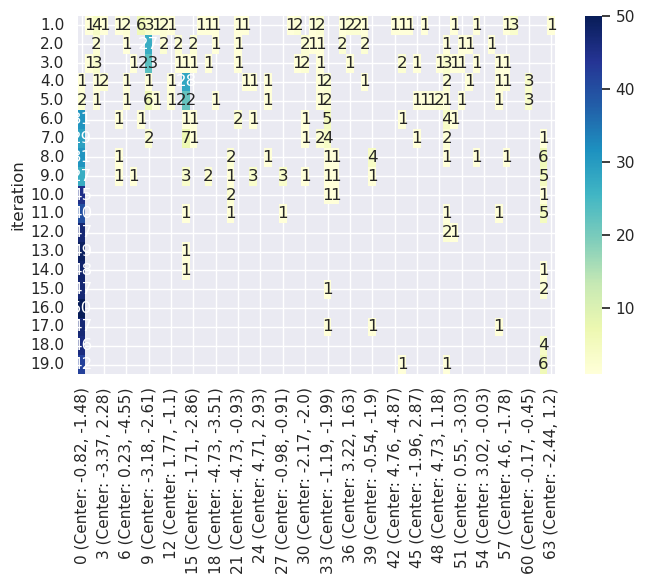

F14_I1_2D AugmentedAEO 2
     iteration  cluster  scaled_raw_y
0          1.0        0  2.923469e-04
1          1.0        2  2.923469e-04
2          1.0        3  2.923469e-04
3          1.0        4  2.923469e-04
4          1.0        6  2.923469e-04
..         ...      ...           ...
166       18.0       62  1.885493e-08
167       19.0        0  1.885493e-08
168       19.0       14  1.885493e-08
169       19.0       26  1.885493e-08
170       19.0       62  1.885493e-08

[171 rows x 3 columns]
Axes(0.125,0.11;0.775x0.77)


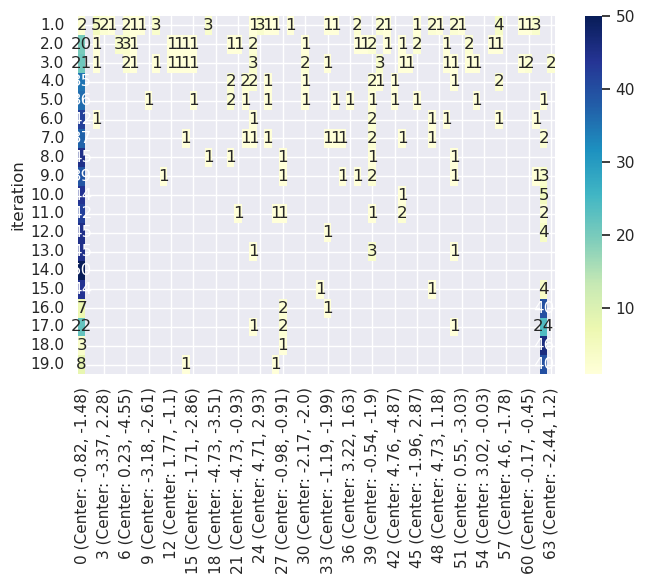

F14_I1_2D AugmentedAEO 3
     iteration  cluster  scaled_raw_y
0          1.0        1      0.022050
1          1.0        2      0.022050
2          1.0        3      0.022050
3          1.0        4      0.022050
4          1.0        6      0.022050
..         ...      ...           ...
155       18.0       62      0.000007
156       19.0        0      0.000007
157       19.0       12      0.000007
158       19.0       27      0.000007
159       19.0       39      0.000007

[160 rows x 3 columns]
Axes(0.125,0.11;0.775x0.77)


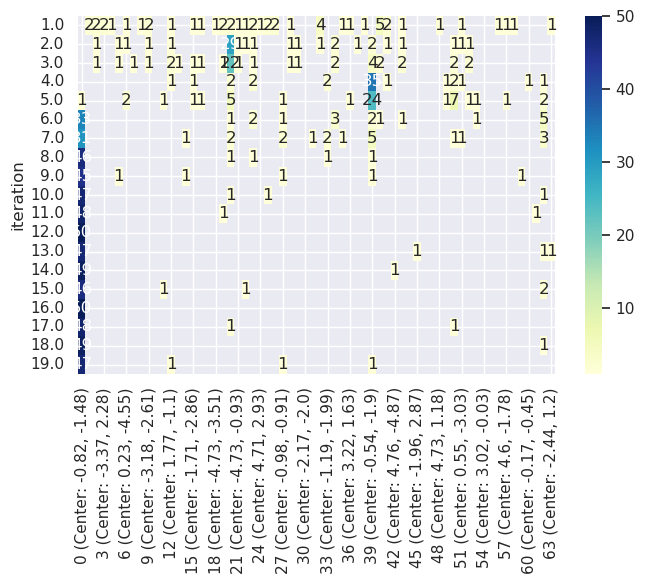

F14_I1_2D AugmentedAEO 4
     iteration  cluster  scaled_raw_y
0          1.0        2  5.219785e-02
1          1.0        3  5.219785e-02
2          1.0        7  7.676638e-03
3          1.0        8  7.676638e-03
4          1.0       10  7.676638e-03
..         ...      ...           ...
153       18.0       62  4.841885e-07
154       19.0       26  4.841885e-07
155       19.0       43  4.841885e-07
156       19.0       62  4.660649e-07
157       19.0       63  4.660649e-07

[158 rows x 3 columns]
Axes(0.125,0.11;0.775x0.77)


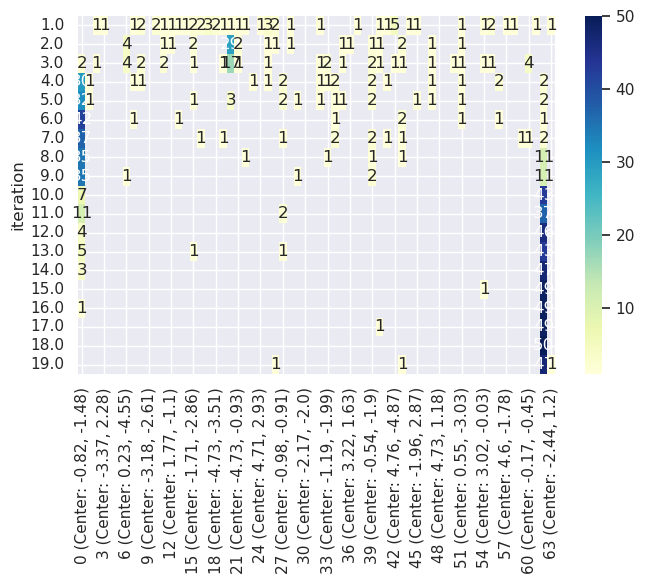

F14_I1_2D BaseDE 0
     iteration  cluster  scaled_raw_y
0          1.0        1  1.127198e-02
1          1.0        3  1.127198e-02
2          1.0        6  1.127198e-02
3          1.0        8  1.127198e-02
4          1.0        9  7.761985e-03
..         ...      ...           ...
280       18.0       39  1.423002e-06
281       18.0       62  1.507959e-07
282       19.0        0  1.507959e-07
283       19.0       27  1.507959e-07
284       19.0       62  1.507959e-07

[285 rows x 3 columns]
Axes(0.125,0.11;0.775x0.77)


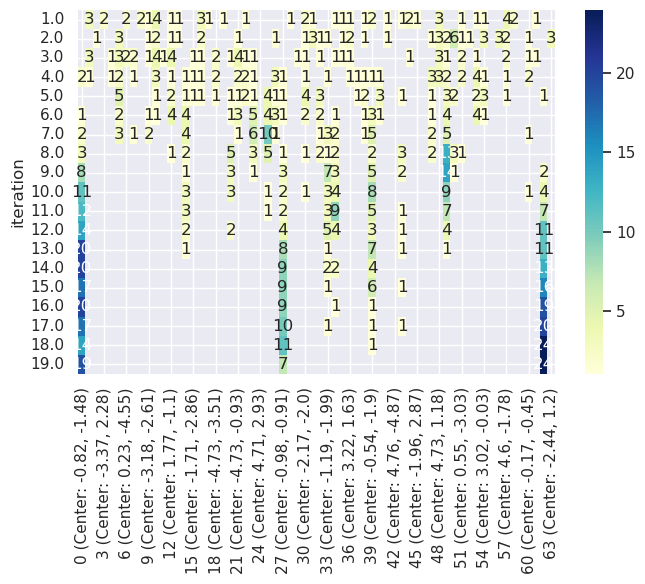

F14_I1_2D BaseDE 1
     iteration  cluster  scaled_raw_y
0          1.0        2      0.049761
1          1.0        3      0.049761
2          1.0        4      0.049761
3          1.0        5      0.008796
4          1.0        6      0.008796
..         ...      ...           ...
330       18.0       62      0.000008
331       19.0        0      0.000008
332       19.0       27      0.000008
333       19.0       39      0.000008
334       19.0       62      0.000008

[335 rows x 3 columns]
Axes(0.125,0.11;0.775x0.77)


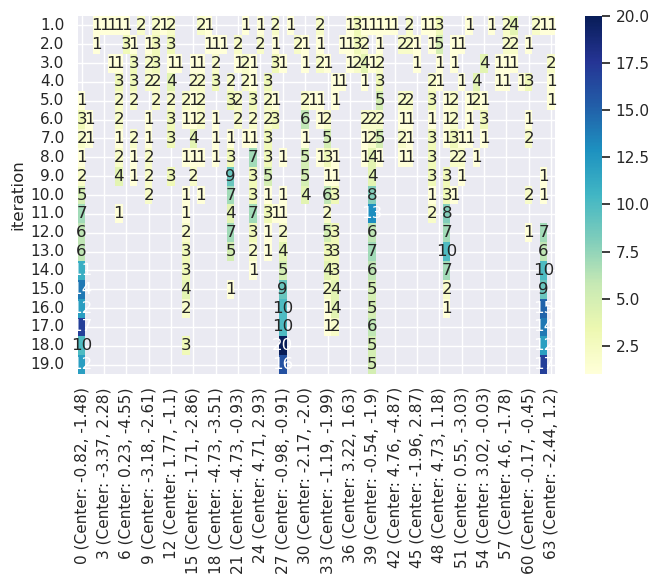

F14_I1_2D BaseDE 2
     iteration  cluster  scaled_raw_y
0          1.0        1      0.010424
1          1.0        2      0.010424
2          1.0        6      0.010424
3          1.0        7      0.004245
4          1.0        8      0.004245
..         ...      ...           ...
288       18.0       27      0.000008
289       18.0       62      0.000008
290       19.0        0      0.000008
291       19.0       27      0.000008
292       19.0       62      0.000003

[293 rows x 3 columns]
Axes(0.125,0.11;0.775x0.77)


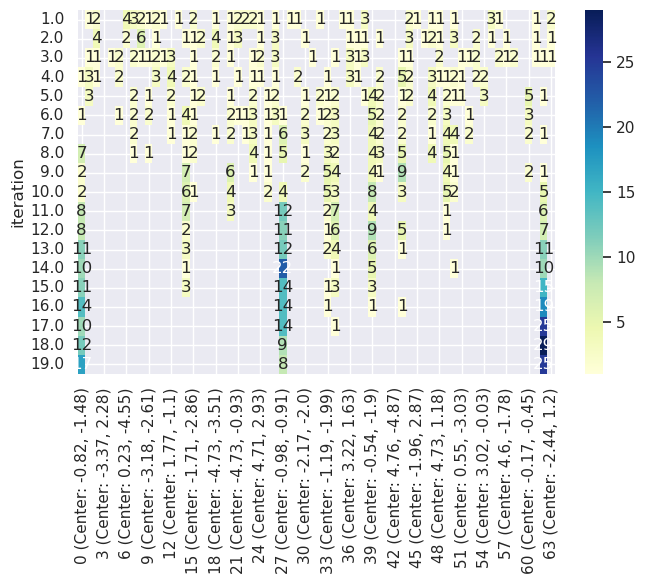

F14_I1_2D BaseDE 3
     iteration  cluster  scaled_raw_y
0          1.0        1  2.010397e-02
1          1.0        2  2.010397e-02
2          1.0        3  2.010397e-02
3          1.0        4  2.010397e-02
4          1.0        6  2.010397e-02
..         ...      ...           ...
290       18.0       27  3.187329e-06
291       18.0       62  4.439869e-07
292       19.0        0  4.439869e-07
293       19.0       27  4.439869e-07
294       19.0       62  4.439869e-07

[295 rows x 3 columns]
Axes(0.125,0.11;0.775x0.77)


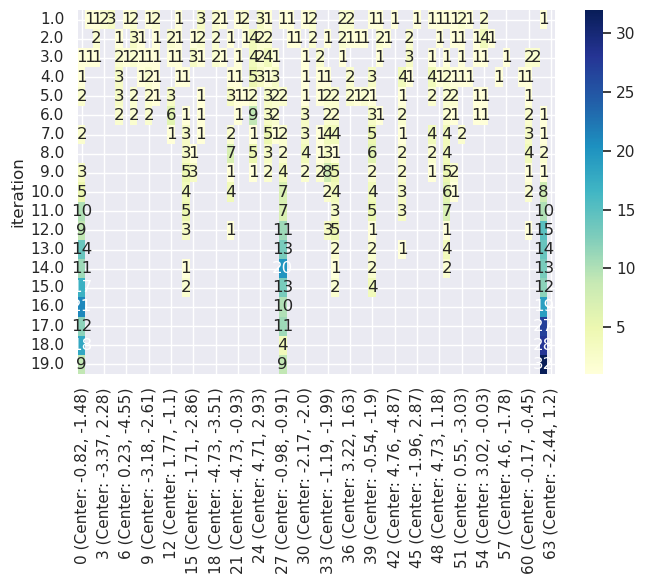

F14_I1_2D BaseDE 4
     iteration  cluster  scaled_raw_y
0          1.0        3  1.503414e-01
1          1.0        6  9.041698e-02
2          1.0        8  9.041698e-02
3          1.0       10  1.323876e-02
4          1.0       11  1.323876e-02
..         ...      ...           ...
300       18.0       27  2.839342e-07
301       18.0       62  2.839342e-07
302       19.0        0  2.839342e-07
303       19.0       27  2.839342e-07
304       19.0       62  2.839342e-07

[305 rows x 3 columns]
Axes(0.125,0.11;0.775x0.77)


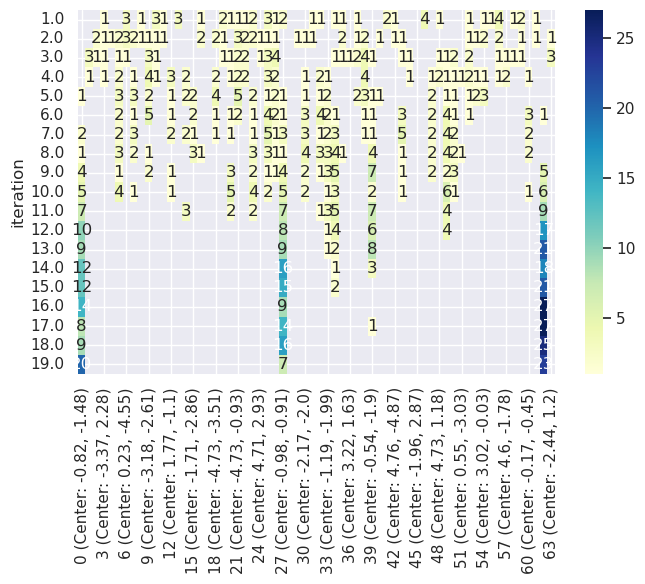

In [434]:
visualize([2], ['F14_I1_2D'], ['AugmentedAEO','BaseDE'], [0,1,2,3,4], data_dir=f'../data/clustering_features_x_only_10_algorithms_kmeans_2pow_no_init', plot_y=False)

In [370]:
algorithms_of_interest=["ModifiedAEO",
"EnhancedAEO",
"OriginalAEO",
"AugmentedAEO",
"SHADE",
"SADE",
"JADE",
"BaseDE",
"OriginalWOA",
"HI_WOA"]

    scaled_x0  scaled_x1  scaled_x2  scaled_x3  scaled_x4
0   -1.287632   2.035998   3.403008   1.942857  -1.070084
1   -0.305285  -1.964255   1.154067  -0.481144   0.595025
2    2.932646   0.506992  -1.868272  -2.923824  -1.990291
3   -3.743201  -1.370417   1.697774   2.035874  -3.958323
4    0.967225  -4.217415   1.329691  -3.631273  -0.786000
..        ...        ...        ...        ...        ...
59  -3.951812   1.046092   4.077780   2.088682   0.677656
60  -3.394628  -1.612989   1.198323  -0.432175   0.834405
61  -0.834558   3.738143   3.359003   3.148637   2.820265
62   0.129208   1.343064   1.884692  -2.795475  -0.496252
63   3.636008   3.069301   2.785506  -3.439236   0.075052

[64 rows x 5 columns]
{0: '-1.29, 2.04, 3.4, 1.94, -1.07', 1: '-0.31, -1.96, 1.15, -0.48, 0.6', 2: '2.93, 0.51, -1.87, -2.92, -1.99', 3: '-3.74, -1.37, 1.7, 2.04, -3.96', 4: '0.97, -4.22, 1.33, -3.63, -0.79', 5: '0.91, 3.64, 3.91, -3.39, 0.33', 6: '-4.46, -4.35, -4.45, -4.15, -4.58', 7: '-0.35, -2.83, 

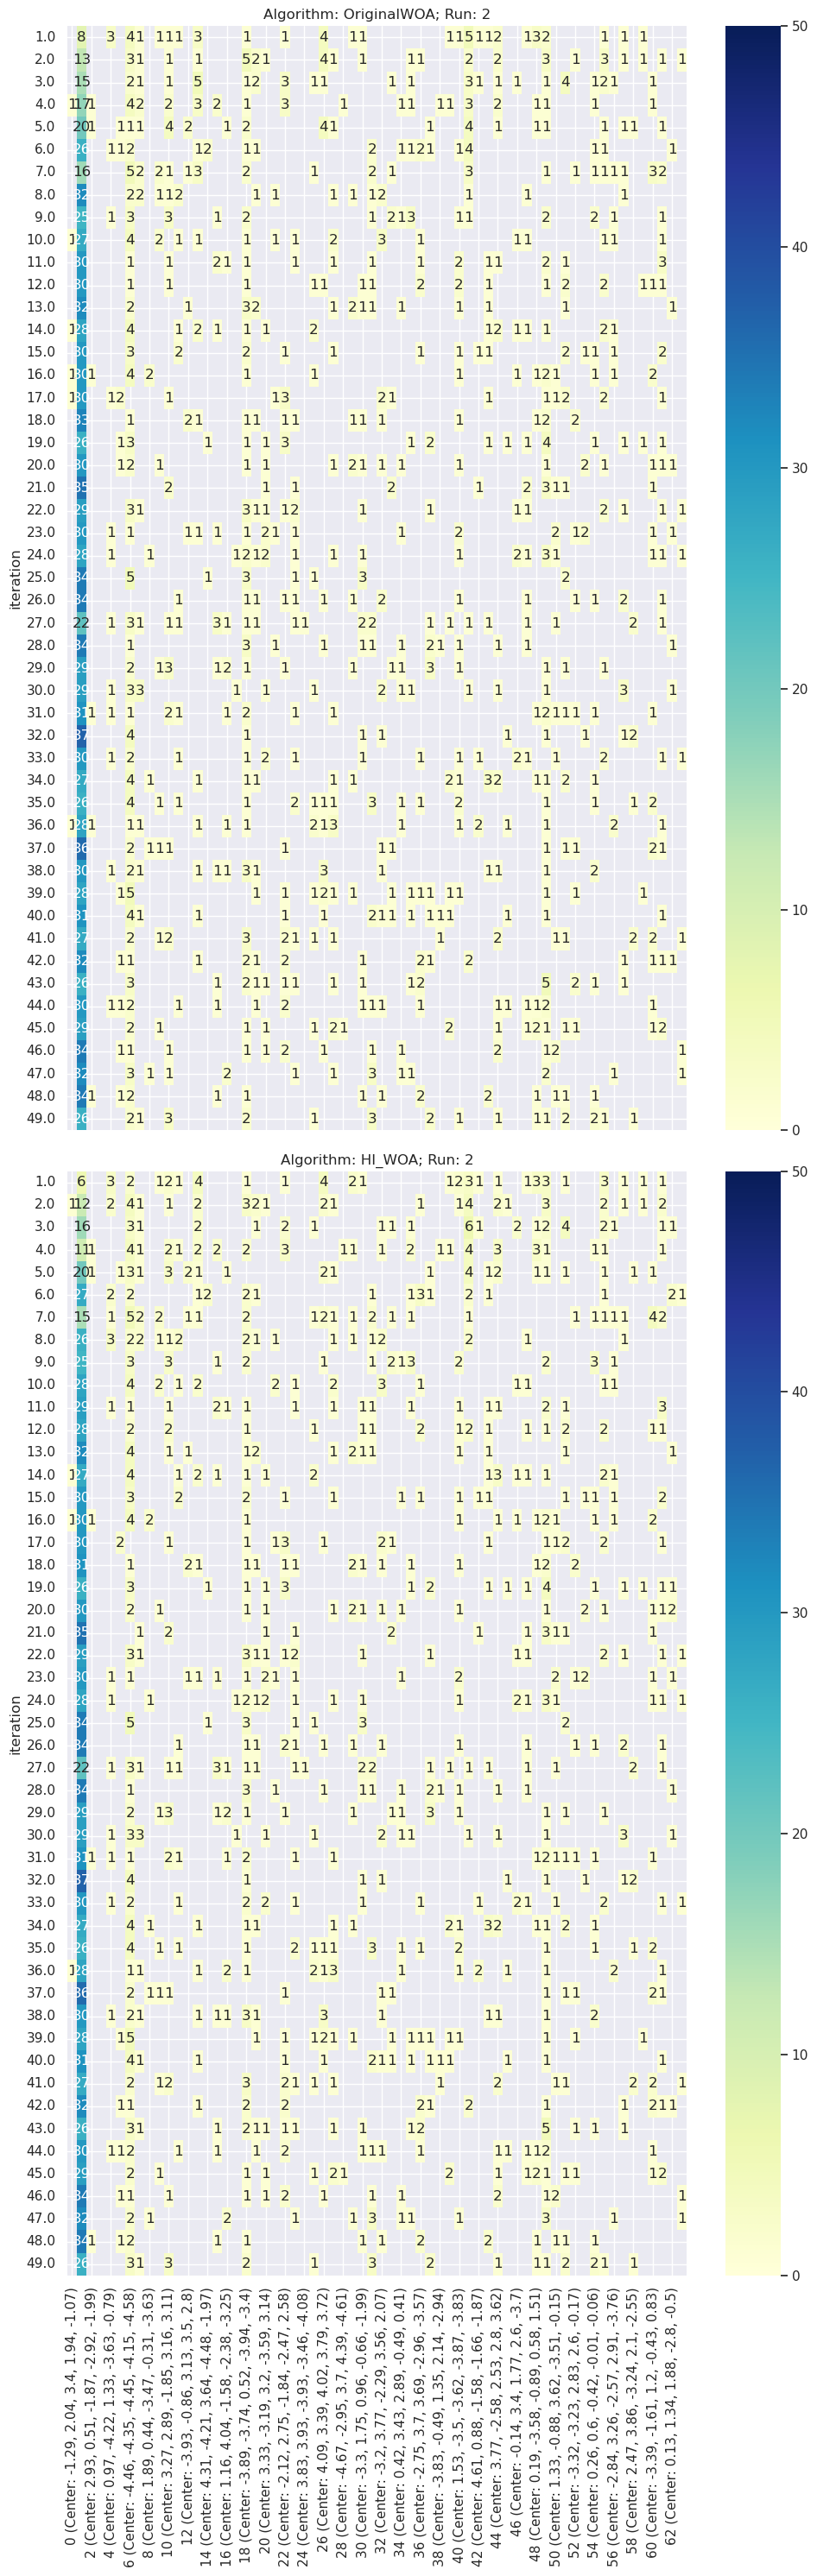

In [425]:
visualize_multi([5], ['F22_I4_5D'], ["OriginalWOA","HI_WOA"], [2], data_dir=f'../data/clustering_features_x_only_10_algorithms_kmeans_2pow_no_init', save=True)

In [ ]:
visualize([10], ['F1_I1_10D'], ['ABFO','AdaptiveEO'], [0,1,2])

In [421]:
dimension=5
directory=f'../data/clustering_features_x_only_10_algorithms_kmeans_2pow_no_init/cluster_distributions/dim_{dimension}'

trajectory_similarities=[]
for file in tqdm(os.listdir(directory)):
    file_loc=f'{directory}/{file}'
    if os.path.isfile(file_loc):
        df=pd.read_csv(file_loc,index_col=[0,1,2])
        d_algorithm_run=df.unstack(level=-1).dropna()
        #d_algorithm_run=pd.DataFrame(MinMaxScaler().fit_transform(d_algorithm_run), index=d_algorithm_run.index, columns=d_algorithm_run.columns).dropna()
        cs=pd.DataFrame(cosine_similarity(d_algorithm_run), index=d_algorithm_run.index, columns=d_algorithm_run.index)
        c=cs.reset_index().rename(columns={'algorithm':'algorithm2', 'run':'run2'}).melt(id_vars=[('algorithm2',  ''),('run2',  '')], value_vars=list(cs.columns)).rename(columns={('algorithm2',  ''): 'algorithm2', ('run2',''):'run2'})
        trajectory_similarities+=[c.assign(problem=file.replace('.csv',''))]

trajectory_similarities=pd.concat(trajectory_similarities)
t=trajectory_similarities.groupby('algorithm').count()['run']
t_max=t.max()
algorithms_to_remove=list(t[t<t_max].index)
trajectory_similarities=trajectory_similarities.query('algorithm not in @algorithms_to_remove and algorithm2 not in @algorithms_to_remove')
trajectory_similarities['problem_class']=[int(tt.split('_')[0].replace('F','')) for tt in trajectory_similarities['problem']]
trajectory_similarities['instance']=[int(tt.split('_')[1].replace('I','')) for tt in trajectory_similarities['problem']]

100%|██████████| 120/120 [00:13<00:00,  9.00it/s]


In [424]:
trajectory_similarities.query('algorithm!=algorithm2').sort_values('value')

algorithm2  run2     algorithm  run     value    problem  \
700   AugmentedAEO   0.0   EnhancedAEO  4.0  0.000295  F20_I4_5D   
14     EnhancedAEO   4.0  AugmentedAEO  0.0  0.000295  F20_I4_5D   
1850  AugmentedAEO   0.0   OriginalWOA  2.0  0.000297  F24_I5_5D   
37     OriginalWOA   2.0  AugmentedAEO  0.0  0.000297  F24_I5_5D   
1951  AugmentedAEO   1.0   OriginalWOA  4.0  0.000300  F17_I5_5D   
...            ...   ...           ...  ...       ...        ...   
938    OriginalWOA   3.0        HI_WOA  3.0  0.995787  F17_I4_5D   
1867        HI_WOA   2.0   OriginalWOA  2.0  0.995979  F10_I2_5D   
887    OriginalWOA   2.0        HI_WOA  2.0  0.995979  F10_I2_5D   
1867        HI_WOA   2.0   OriginalWOA  2.0  0.996087  F22_I4_5D   
887    OriginalWOA   2.0        HI_WOA  2.0  0.996087  F22_I4_5D   

      problem_class  instance  
700              20         4  
14               20         4  
1850             24         5  
37               24         5  
1951             17         5  
...             ...       ...  
938              17         4  
1867             10         2  
887              10         2  
1867             22         4  
887              22         4  

[270000 rows x 8 columns]

100%|██████████| 120/120 [00:50<00:00,  2.38it/s]


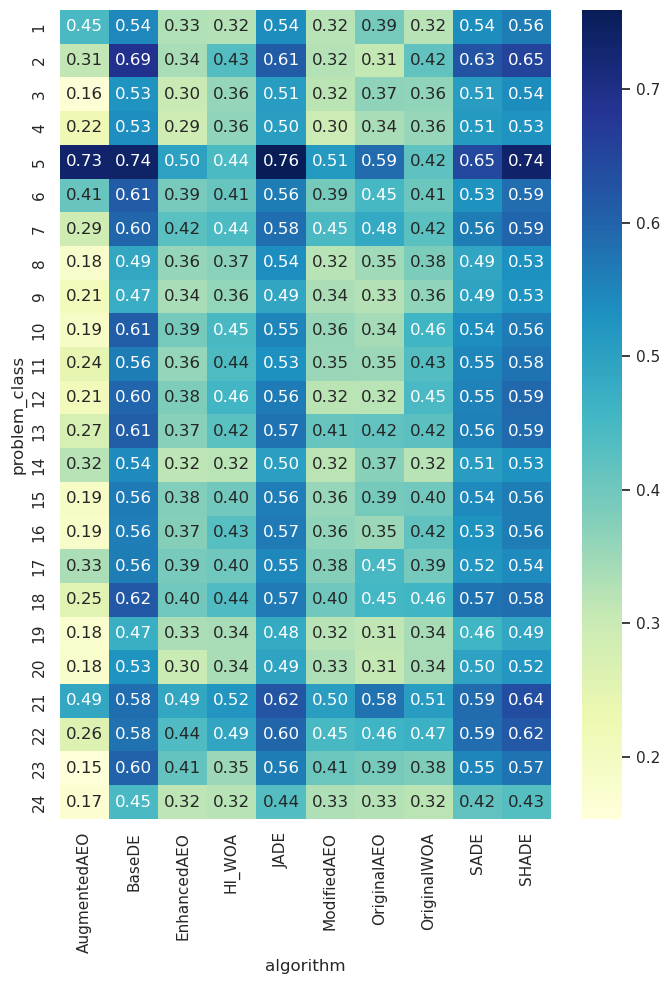

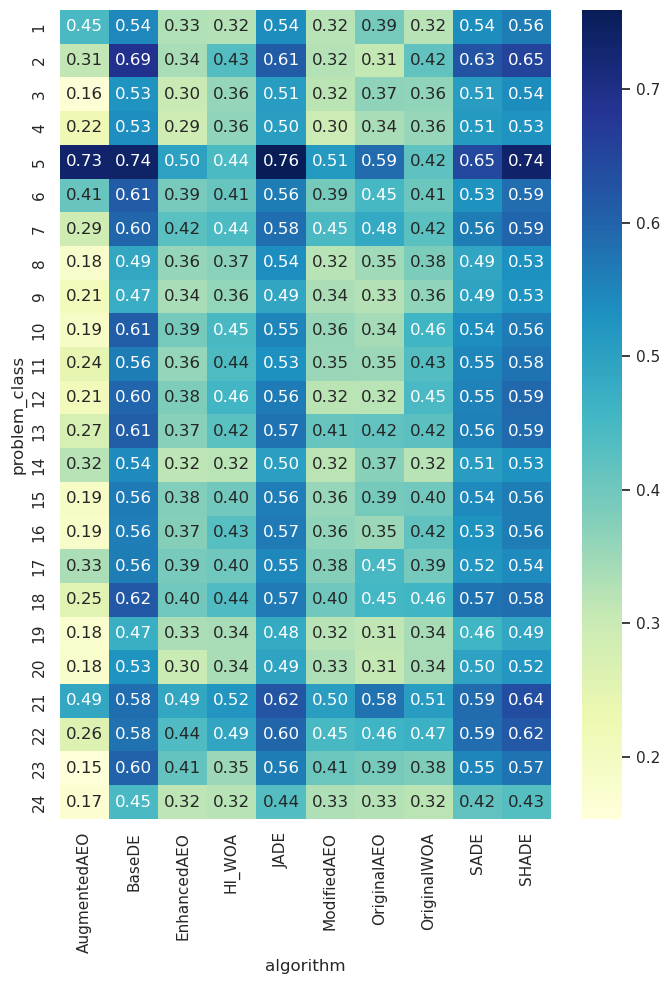

<Figure size 600x600 with 0 Axes>

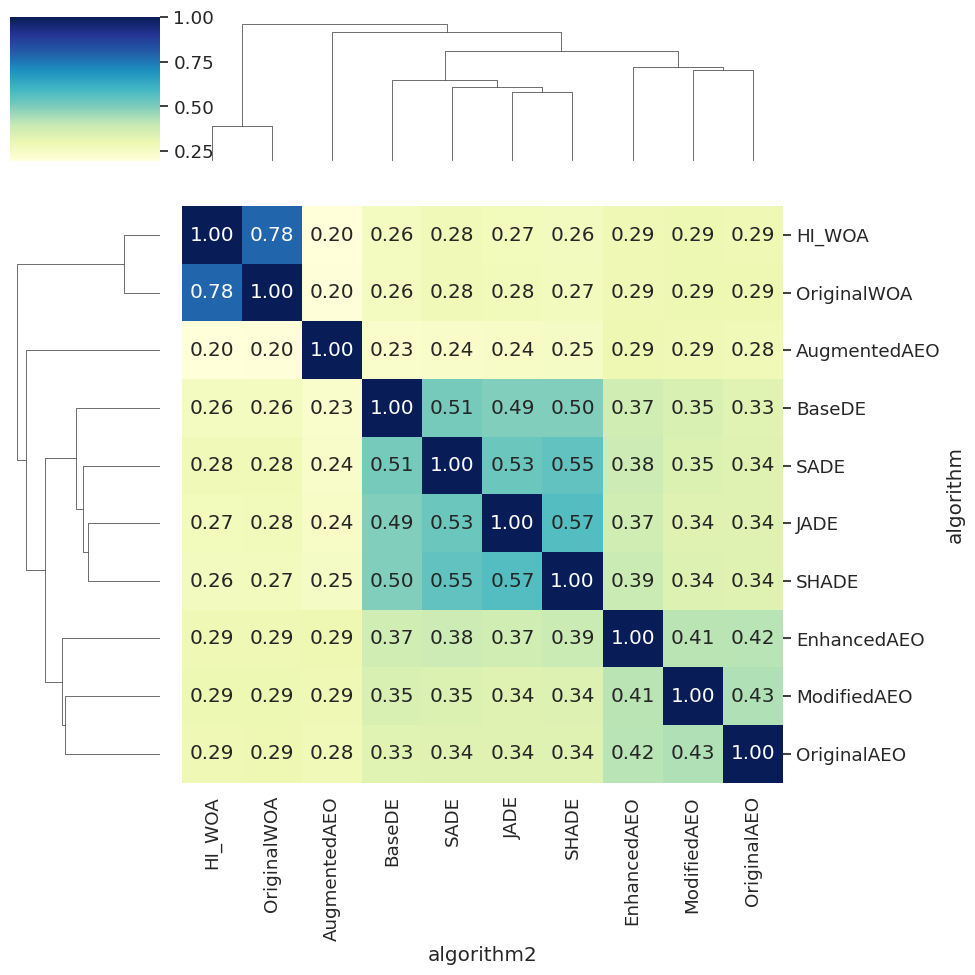

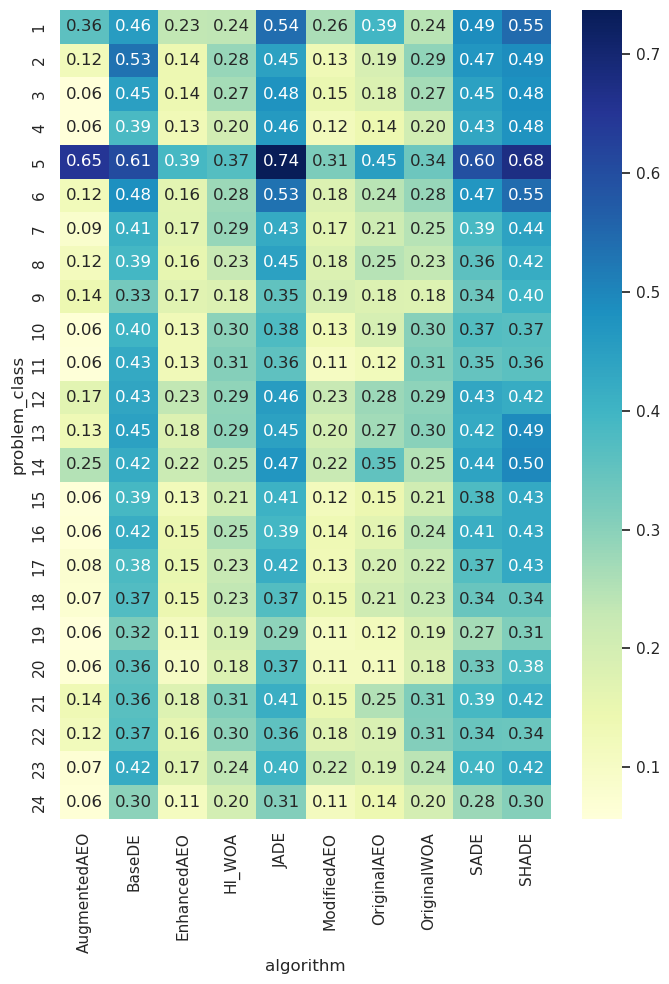

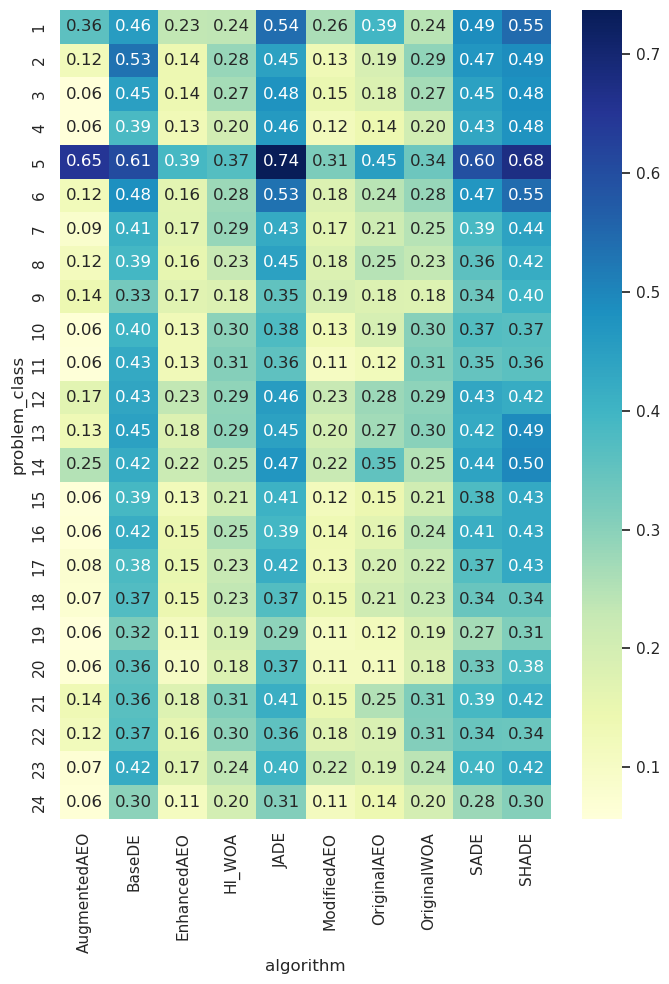

<Figure size 600x600 with 0 Axes>

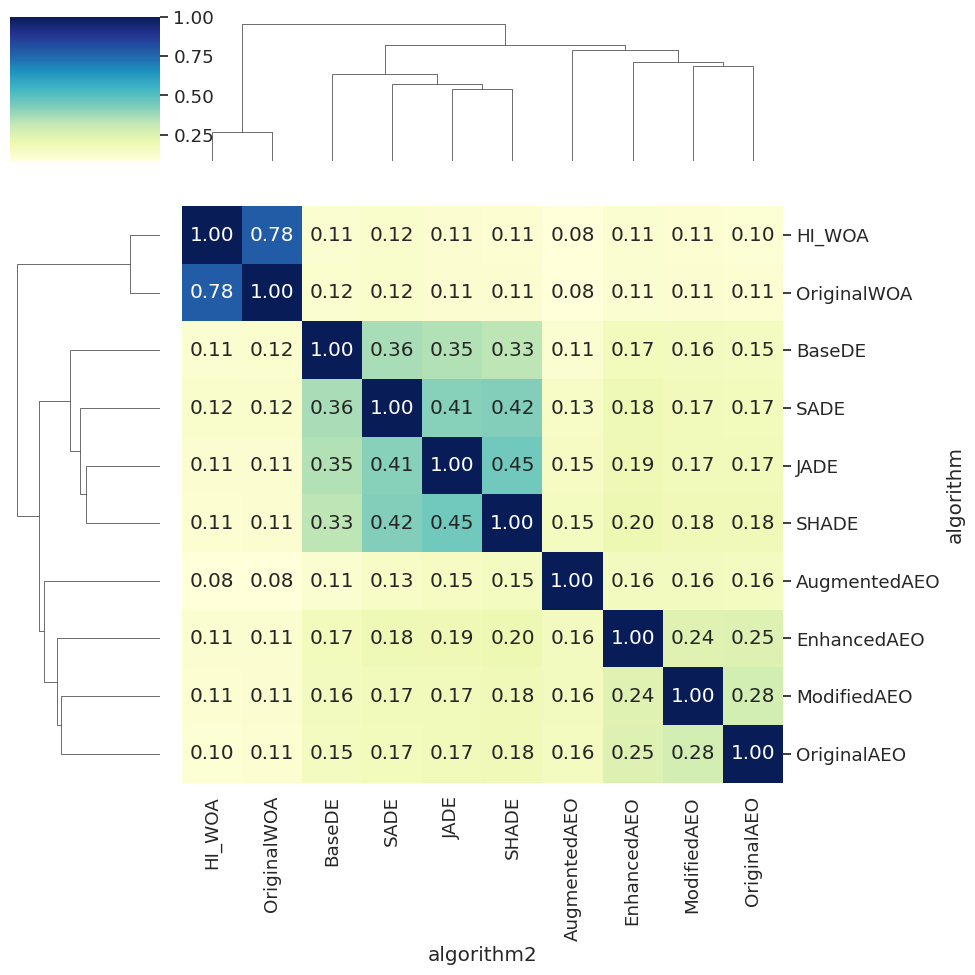

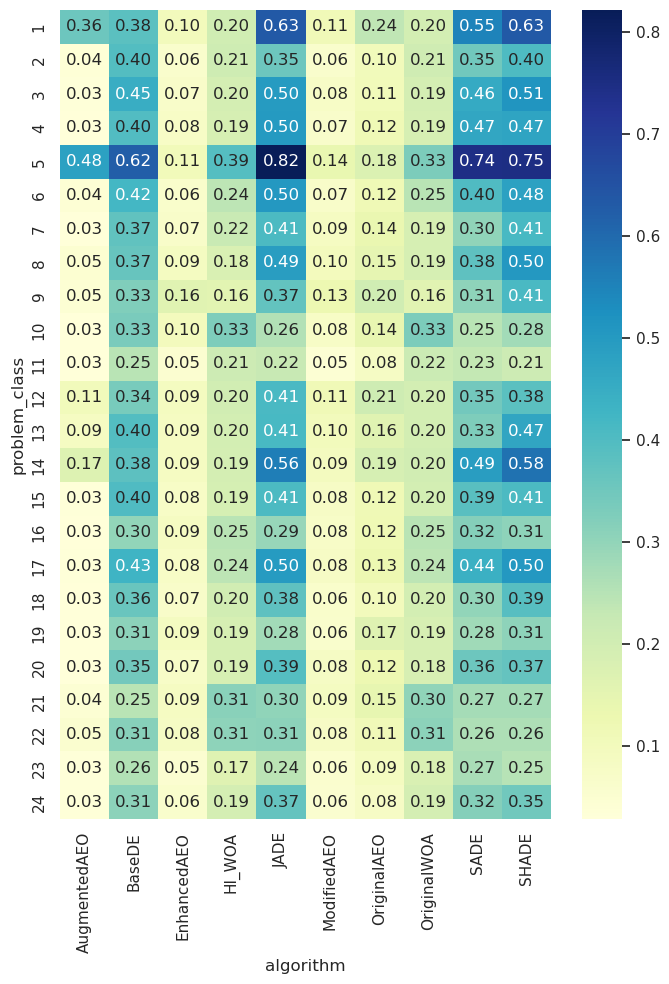

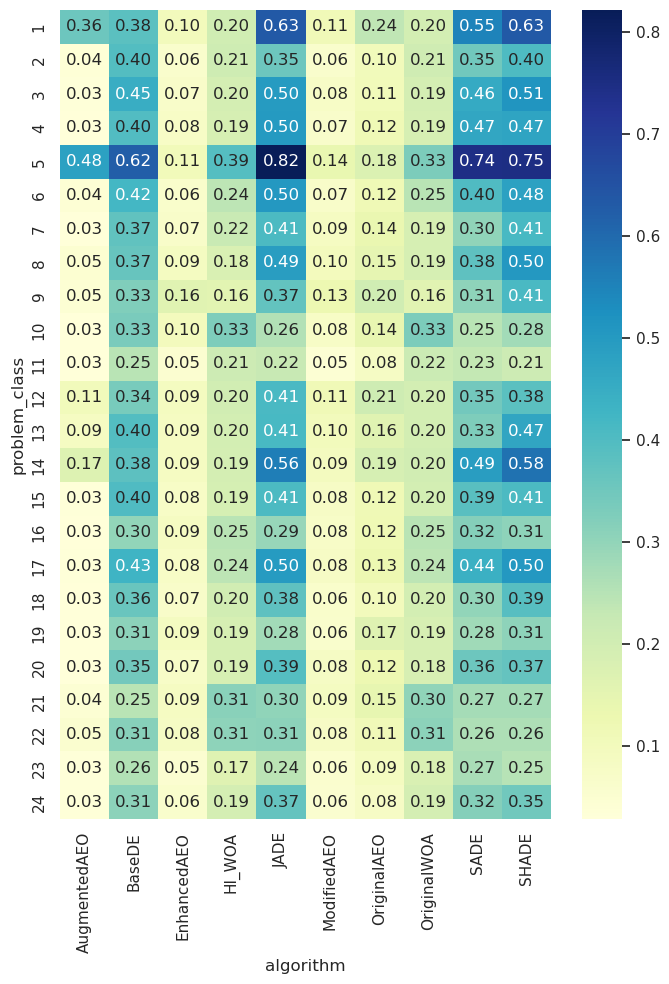

<Figure size 600x600 with 0 Axes>

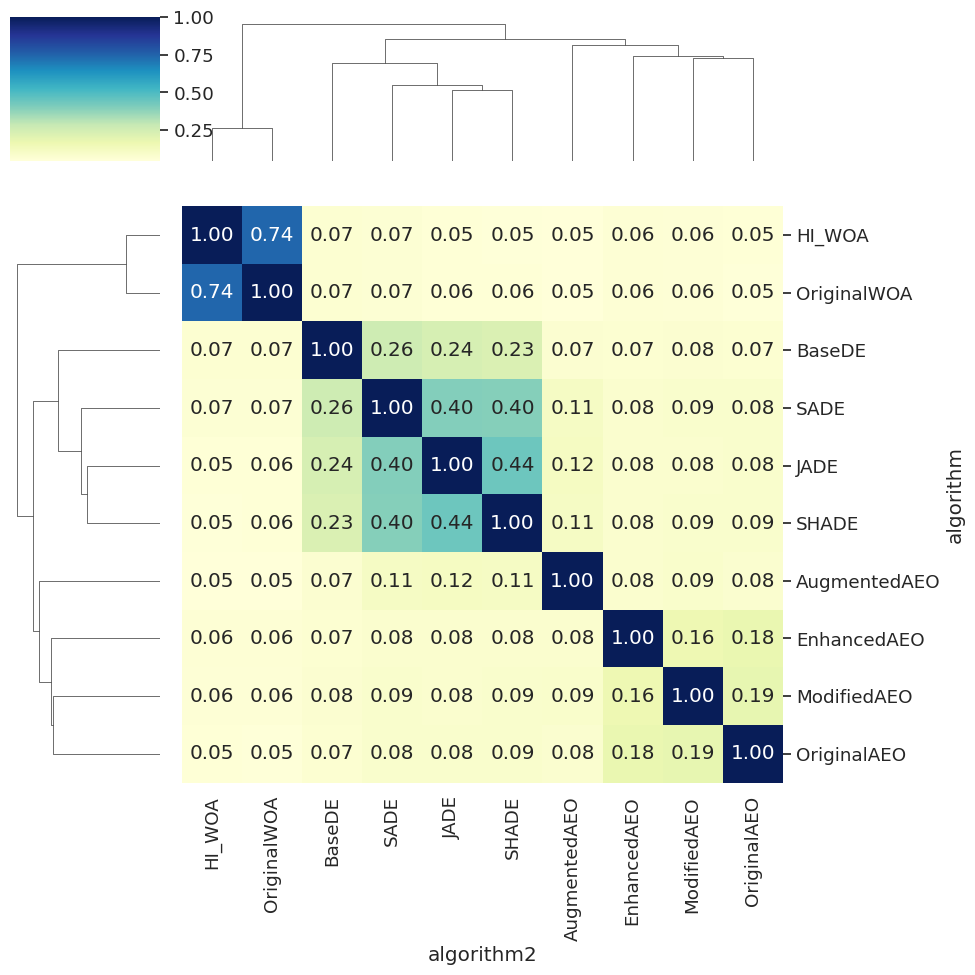

In [429]:
for dimension in [2,5,10]:
    directory=f'../data/clustering_features_x_only_10_algorithms_kmeans_2pow_no_init/cluster_distributions/dim_{dimension}'
    scale=False
    trajectory_similarities=[]
    for file in tqdm(os.listdir(directory)):
        file_loc=f'{directory}/{file}'
        if os.path.isfile(file_loc):
            df=pd.read_csv(file_loc,index_col=[0,1,2])
            d_algorithm_run=df.unstack(level=-1).dropna()
            d_algorithm_run=pd.DataFrame(MinMaxScaler().fit_transform(d_algorithm_run), index=d_algorithm_run.index, columns=d_algorithm_run.columns).dropna()
            cs=pd.DataFrame(cosine_similarity(d_algorithm_run), index=d_algorithm_run.index, columns=d_algorithm_run.index)
            c=cs.reset_index().rename(columns={'algorithm':'algorithm2', 'run':'run2'}).melt(id_vars=[('algorithm2',  ''),('run2',  '')], value_vars=list(cs.columns)).rename(columns={('algorithm2',  ''): 'algorithm2', ('run2',''):'run2'})
            trajectory_similarities+=[c.assign(problem=file.replace('.csv',''))]
    
    trajectory_similarities=pd.concat(trajectory_similarities)
    t=trajectory_similarities.groupby('algorithm').count()['run']
    t_max=t.max()
    algorithms_to_remove=list(t[t<t_max].index)
    trajectory_similarities=trajectory_similarities.query('algorithm not in @algorithms_to_remove and algorithm2 not in @algorithms_to_remove')
    trajectory_similarities['problem_class']=[int(tt.split('_')[0].replace('F','')) for tt in trajectory_similarities['problem']]
    trajectory_similarities['instance']=[int(tt.split('_')[1].replace('I','')) for tt in trajectory_similarities['problem']]

    plt.figure(figsize=(7,10))
    sim_per_problem_algorithm=trajectory_similarities.query('algorithm==algorithm2 and run!=run2').groupby(['problem_class','algorithm'])['value'].mean()
    sns.heatmap(sim_per_problem_algorithm.reset_index().pivot(index='problem_class',columns='algorithm',values='value').sort_index(),annot=True,fmt=".2f", cmap='YlGnBu')
    plt.tight_layout()
    plt.savefig(f'figures_clustering_new/algorithm_similarity_per_problem_dim_{dimension}_scale_{scale}.pdf')


    plt.figure(figsize=(7,10))
    sim_per_problem_algorithm=trajectory_similarities.query('algorithm==algorithm2 and run!=run2').groupby(['problem_class','algorithm'])['value'].mean()
    sns.heatmap(sim_per_problem_algorithm.reset_index().pivot(index='problem_class',columns='algorithm',values='value').sort_index(),annot=True,fmt=".2f", cmap='YlGnBu')
    plt.tight_layout()
    plt.savefig(f'figures_clustering_new/algorithm_stability_per_problem_dim_{dimension}_scale_{scale}.pdf')

    cross_algorithm_similarity=trajectory_similarities.query('run==run2').groupby(['algorithm','algorithm2'])['value'].mean()
    cross_algorithm_similarity_pivoted=cross_algorithm_similarity.reset_index().pivot(index='algorithm',columns='algorithm2',values='value')
    sns.set(font_scale=1.2)
    plt.figure(figsize=(6,6))
    sns.clustermap(cross_algorithm_similarity_pivoted,annot=True,fmt=".2f", cmap='YlGnBu')
    plt.tight_layout()
    plt.savefig(f'figures_clustering_new/algorithm_mean_similarity_clustermap_dim_{dimension}_scale_{scale}.pdf')
    sns.set(font_scale=1)


In [10]:
optimizer_group=get_algorithm_groups()


In [11]:
cross_algorithm_similarity_to_save=cross_algorithm_similarity.reset_index()
cross_algorithm_similarity_to_save['algorithm_group']=cross_algorithm_similarity_to_save['algorithm'].apply(lambda x: optimizer_group[x])
cross_algorithm_similarity_to_save['algorithm2_group']=cross_algorithm_similarity_to_save['algorithm2'].apply(lambda x: optimizer_group[x])
cross_algorithm_similarity_to_save.sort_values('value',ascending=False).query('algorithm!=algorithm2').to_csv(f'../data/clustering_features/algorithm_pairwise_similarity/algorithm_mean_similarity_{dimension}D.csv')

In [12]:

unique_optimizer_groups=list(set(optimizer_group.values()))
#optimizer_group={k:str(v).split('.')[1] for k,v in optimizers.items()}
unique_colors=list(sns.color_palette("tab10"))
group_color={f:unique_colors[fi] for fi, f in enumerate(unique_optimizer_groups)}

unique_optimizer_groups=list(set(optimizer_group.values()))
#optimizer_group={k:str(v).split('.')[1] for k,v in optimizers.items()}
unique_colors=list(sns.color_palette("tab10"))
group_color={f:unique_colors[fi] for fi, f in enumerate(unique_optimizer_groups)}

/opt/conda/envs/Base/lib/python3.9/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/opt/conda/envs/Base/lib/python3.9/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


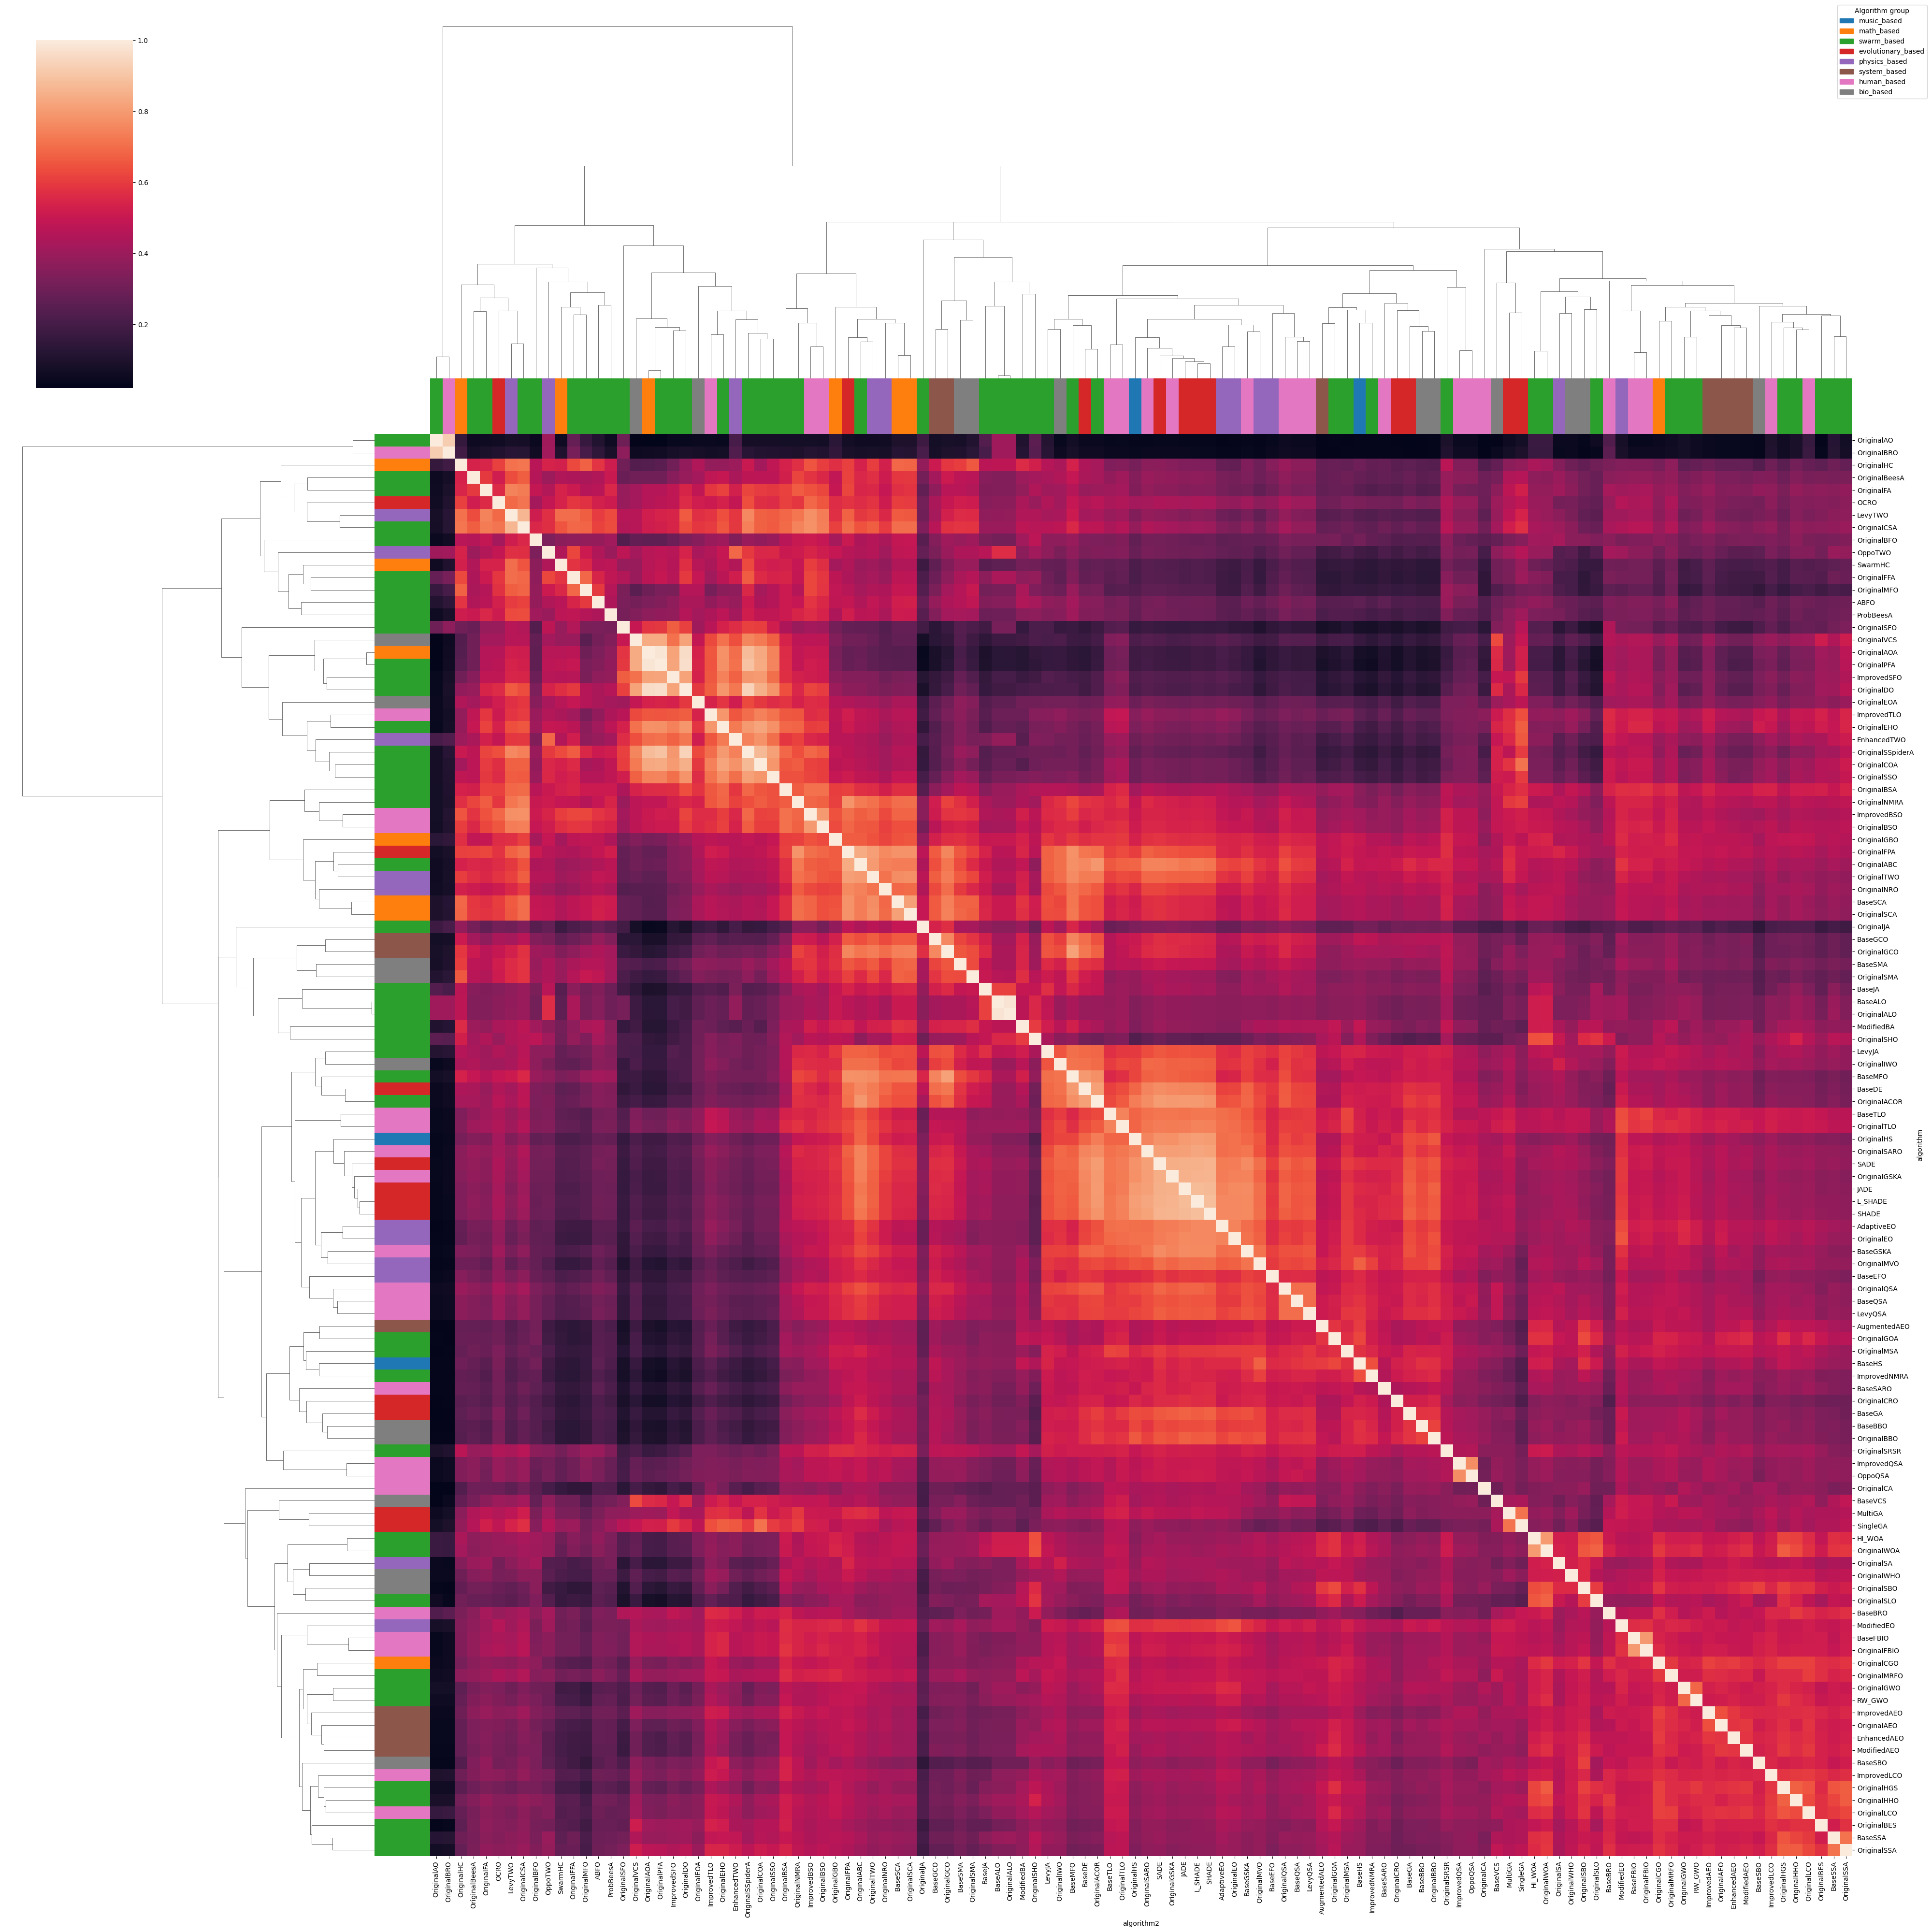

In [13]:
row_colors=[group_color[optimizer_group[o]] for o in cross_algorithm_similarity_pivoted.index]
col_colors=[group_color[optimizer_group[o]] for o in cross_algorithm_similarity_pivoted.columns]
sns.clustermap(cross_algorithm_similarity_pivoted, row_colors=row_colors, col_colors=col_colors,figsize=(40,40))
handles = [mpatches.Patch(color=color, label=label) for label, color in group_color.items()]
# Add legend to the clustermap
plt.legend(handles=handles, title='Algorithm group', bbox_to_anchor=(1, 1), bbox_transform=plt.gcf().transFigure)

plt.savefig(f'figures_clustering/algorithm_mean_similarity_clustermap_dim{dimension}.pdf')
plt.show()
